# Assignment 3: Neural Networks for Quantum State Tomography

<span style="color:red">

## For this assignment, I followed the convention used in the lecture. Specifically, I considered the validation test to be part of the training phase. Consequently, the validation loss is computed at the end of each epoch, while the test loss is only calculated after the training process has concluded, using the final parameters. This allows for an assessment of the overall performance of the model.

</span>


In this assignment you will train a neural network to fit the distribution of a quantum state from few measurements of it. Even though this problem has applications in physics, for the purpose of this exercise we will mainly consider it as a regression problem, without concerning us with the physics behind it.

> ⚠️ As usual, we will execute your notebook again when grade you. Please, make sure that it takes no longer than 15min (on google colab) to run from top to bottom. You should be able to solve the exercises without GPU acceleration, but feel free to add it if you want. Comment out code used for exploration where we ask you.


## Introducing the problem: Quantum State Tomography

We are given a dataset with $N$ samples $\{x_i,y_i \}_{i = 1, ..., N}$ where $x_i = \{0,1\}^{\mathtt{n\_spins}}$ is a binary string of length $\mathtt{n\_spins}$ and $y_i \in (0,1]$ is a  number. We have our regression problem.

But where is the data from? We are considering the case where the $x_i$ are the the possible outcomes of a measurement of a quantum state $\Psi$ and $y_i$ is the probability of observing outcome $x_i$.
Our goal is to train a neural network $f_\theta(x) = \hat{y}$ that approximates the original probability distribution. Specifically, for the set of possible outcomes $\{x_i\}$, the model should return a vector of probabilities corresponding to each outcome.


## Exercise 1 (10 pts): A fully connected network

For the purpose of this exercise, we give you a function that samples $N$ measurements from a quantum state along with their probabilities.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def get_data(n_spins):
    
    # Loads the data available in the .txt files we made available to you.
    
    if n_spins not in [8,12,16]:
        raise ValueError(f"The data for {n_spins} is not available.")
        
    numbers = [bin(i)[2:].zfill(n_spins) for i in range(2**n_spins)]
    xs = [[int(char) for char in string] for string in numbers]
    X = np.array(xs)
    
    Wstate = np.loadtxt(f"target_state_{n_spins}.txt")
    Y = np.abs(Wstate)**2
    
    # shuffle
    idx = np.random.permutation(range(len(Y)))
    
    return X[idx], Y[idx]

a) Load the data for `n_spins=16` and visualize the labels as a histogram. Visualize both `y` and `log(y)` in different plots. Which representation is more informative?

*Answer:* The code providing more informations is the `log(y)` plot. Indeed, it spreads out the highly skewed datas in order to give a better global representation of the underlying distribution of the latter. 

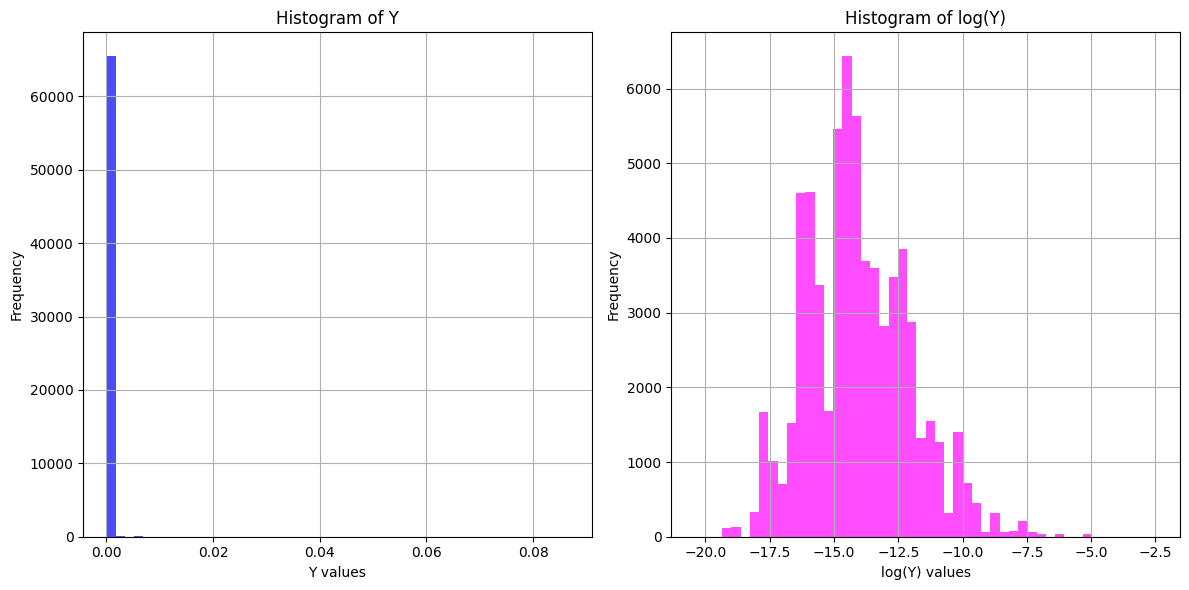

In [2]:
n_spins = 16
X_16, Y_16 = get_data(n_spins)

plt.figure(figsize=(12, 6))

# Plot for Y
plt.subplot(1, 2, 1)
plt.hist(Y_16, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Y')
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.grid()

# Plot for log(Y)
plt.subplot(1, 2, 2)
plt.hist(np.log(Y_16), bins=50, color='fuchsia', alpha=0.7)
plt.title('Histogram of log(Y)')
plt.xlabel('log(Y) values')
plt.ylabel('Frequency')
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()




b) We want to continue working with this datasets in two different forms, either without or with the log-transform of the labels : $\{x_i,y_i\}$ or $\{x_i,log(y_i)\}$. Then we want to train neural networks on this data using SGD. 

Complete the function `get_loaders`. Set `n_spins=12` and apply the log transform according to the normalize variable. Create a test, train and validation dataset using `TensorDataset`, the split should be done at (40%,20%,40%) of the original data. To prepare for training, wrap the new datasets in torch `DataLoaders` as you have seen in previous exercises. For training data loader, use a batch size 32 and use shuffling, for test and validation data loaders use the full batch and don't shuffle. 

In [3]:
def get_loaders(X, Y, normalize_log = False):
    

    if normalize_log:
        Y = np.log(Y)
        #Y = (Y - np.mean(Y)) / np.std(Y) ##the normalization gives stronger results for the rest of the notebook but we keep values non-normalized
                                          ##since it is not required in the task
    
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
    dataset_size = len(dataset)
    test_size=int(0.4*dataset_size)
    train_size=int(0.2*dataset_size)
    validation_size = dataset_size - test_size - train_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=dataset_size, shuffle=False)    ##peut etre il faut prendre len(val_dataset) comme batch_size
    test_loader = DataLoader(test_dataset, batch_size=dataset_size, shuffle=False)  ##peut etre il faut prendre len(test_dataset) comme batch_size
    
    return train_loader, val_loader, test_loader
    
n_spins = 12
X_12_log, Y_12_log = get_data(n_spins)
train_loader, val_loader, test_loader = get_loaders(X_12_log, Y_12_log, normalize_log=True)

c) Define a general function `train` as given below that takes the test and train loaders, a learning rate and a model, a number of epochs and optionally a boolean `logging`equal to `True` by default and returns the train and test losses for every epoch, and the best test loss achieved overall. 

You are supposed to run SGD with the MSE loss. Print the progress of your training by printing the losses every epoch, if `logging==True`.

- I) In the course of your code you will use the line `optimizer.zero_grad()`. Explain briefly what happens when you call this function, and when and why you need to call it.

- II)  Explain why we previously needed to activate the batches and shuffling for the training dataloader. 

- III) When a dataloader is used several times for several epochs, is the data shuffled in the same order every time?

*`Answers:`* 
- I) Everytime we want to compute a new derivative we shall use `optimizer.zero_grad()`, otherwise we add the new gradient to the value previously calculated leading to errors. We therefore assure that the gradient is the one from the current batch.

- II)  Batches allow to improve efficiency, notably memory efficiency because we process on smaller subset with SGD. This leads to faster feedback since model's parameters are updated more frequently (could help to converge faster). On the oter hand shuffling is important in order to break order dependence. This reduces bias helping the model to generalize better. Therefore the key aspects are : memory efficiency, model's ability to generalize, training stability

- III) By definiton, data are shuffled in different order every time so that we break order dependence unless a random seed has been set.

In [4]:
## Note that here we swictched variables since we use validation to fit with what was taught in the course, but we could also use the test set to tune the hyperparameters. 
## Here the two sets can be used interchangeably.

def train(train_loader, test_loader, val_loader, lr, model, n_epochs, logging=True):
    train_losses, validation_losses, test_losses = [], [], []

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(features)
            loss = criterion(outputs[:,0], labels)  
            loss.backward()  
            optimizer.step() 

            running_loss += loss.item()  

        train_losses.append(running_loss / len(train_loader))  

        # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                loss = criterion(outputs[:,0], labels)
                validation_loss += loss.item()

        validation_losses.append(validation_loss / len(val_loader)) 

        if logging:
            print(f'Epoch {epoch+1}/{n_epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, '
                  f'Validation Loss: {validation_losses[-1]:.4f}')
                  
# Testing phase
    model.eval()
    predictions = []
    ground_truth = []
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs[:,0], labels)
            predictions.extend(outputs[:, 0].numpy())  # Stocker les prédictions
            ground_truth.extend(labels.numpy())
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader)) 

    best_val_loss = min(validation_losses)
    return train_losses, test_losses, validation_losses, best_val_loss, predictions, ground_truth


d) Test your function by training a 1 hidden layer fully connected network with ReLU activations. You will choose the hyperparameters: `n_epochs` to train and the `learning rate`. You can keep the number of `hidden_neurons=16` fixed for the moment. Hint: You should not need to use more than 2000 epochs in your explorations...

Write the code to train and visualize the test and train losses with a log-sacle on the y-axis.
It is now your turn to play.

Choose `lr=0.1`, `n_epochs=100` and `hidden_neurons=16`. Train 10 models with these hyperparameters and observe their learning curves. We would expect the learning curves of the 10 different models to be different because every time you define a new model, the weights are initialized randomly and the SGD optimizer will go over the batches in a different order. 

Describe what differences and similarities you observe. How could you change (some of) the hyperparameters so that the runs are more similar, i.e. the loss curve is less strongly dependent on the initialization?

> ⚠️ Once you are ready to answer the question, leave the code you used for your explorations and the learning curves you produced, but comment it so we don't have to run it again. This hold only for this question

*`Answer:`* 
- Similarities : Despite randomness in weights initialization for training phase, we see a general tendency of the loss curves decreasing over epochs with oscillations. Almost all models seem to converge with slightly different rate and final loss but the general trend is the same.  

- Differencies : We know that weights are initialized randomly in the network, showing that every loss curves for the 10 models, begins from a different point and ends with different final losses. Thus, some models seem to converge faster than others which are subject to more oscillations. We also know that SGD optimizer processes data in minibatch but the order in which the datas are shuffled differ among epochs of each model resulting in differencies during the learning process.  

- How to reduce initialization weights dependence ? A possibility would be to fix a seed in order to enhence reproducibility and reduce variablity during the runs. One can also increase batch size in order to reduce the variance in gradient estimates. Others possibilities are adding L2 regularization, reduce the learing rate for stability or even change the optimizer from SGD to Adam.

Training model 1/10
Epoch 1/500, Train Loss: 55.4462, Validation Loss: 3.2813
Epoch 2/500, Train Loss: 3.1588, Validation Loss: 3.1475
Epoch 3/500, Train Loss: 3.1783, Validation Loss: 3.1689
Epoch 4/500, Train Loss: 3.0234, Validation Loss: 3.1063
Epoch 5/500, Train Loss: 3.0235, Validation Loss: 3.0279
Epoch 6/500, Train Loss: 2.9454, Validation Loss: 3.0099
Epoch 7/500, Train Loss: 2.9186, Validation Loss: 3.7107
Epoch 8/500, Train Loss: 2.8212, Validation Loss: 2.9820
Epoch 9/500, Train Loss: 2.8541, Validation Loss: 3.2342
Epoch 10/500, Train Loss: 2.6780, Validation Loss: 2.9543
Epoch 11/500, Train Loss: 2.6180, Validation Loss: 2.7229
Epoch 12/500, Train Loss: 2.5379, Validation Loss: 2.7812
Epoch 13/500, Train Loss: 2.4563, Validation Loss: 2.6070
Epoch 14/500, Train Loss: 2.3035, Validation Loss: 2.5784
Epoch 15/500, Train Loss: 2.2630, Validation Loss: 2.6370
Epoch 16/500, Train Loss: 2.1742, Validation Loss: 2.5068
Epoch 17/500, Train Loss: 2.0847, Validation Loss: 2.3471
Ep

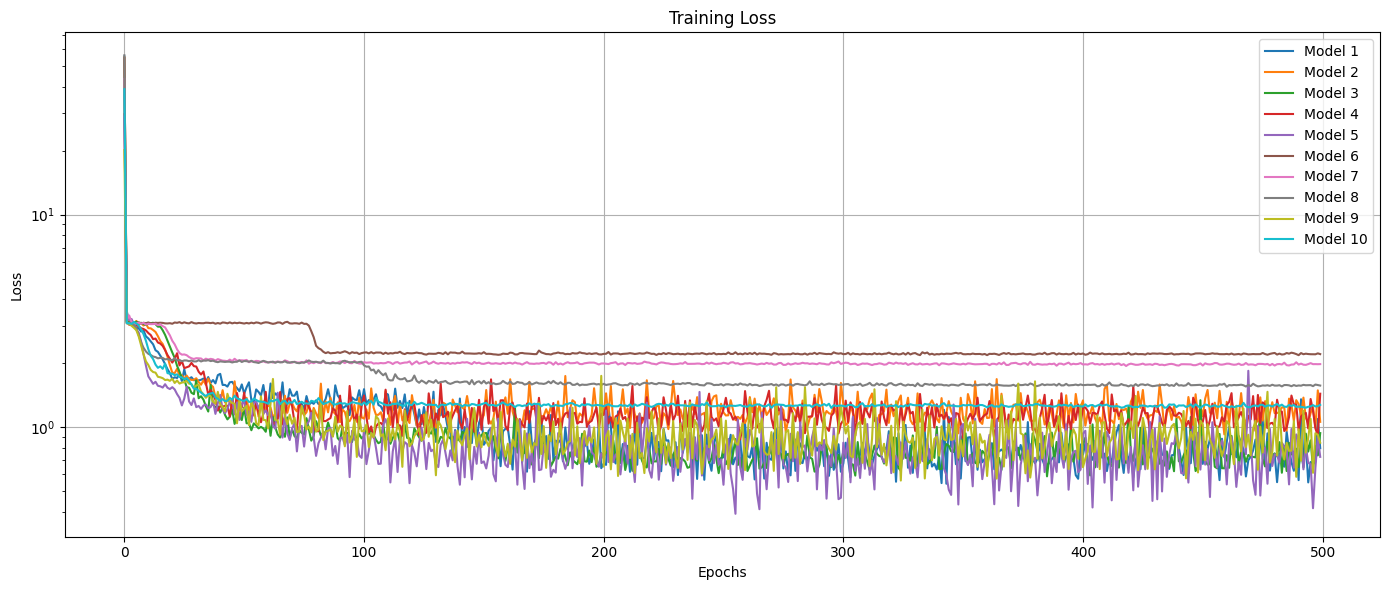

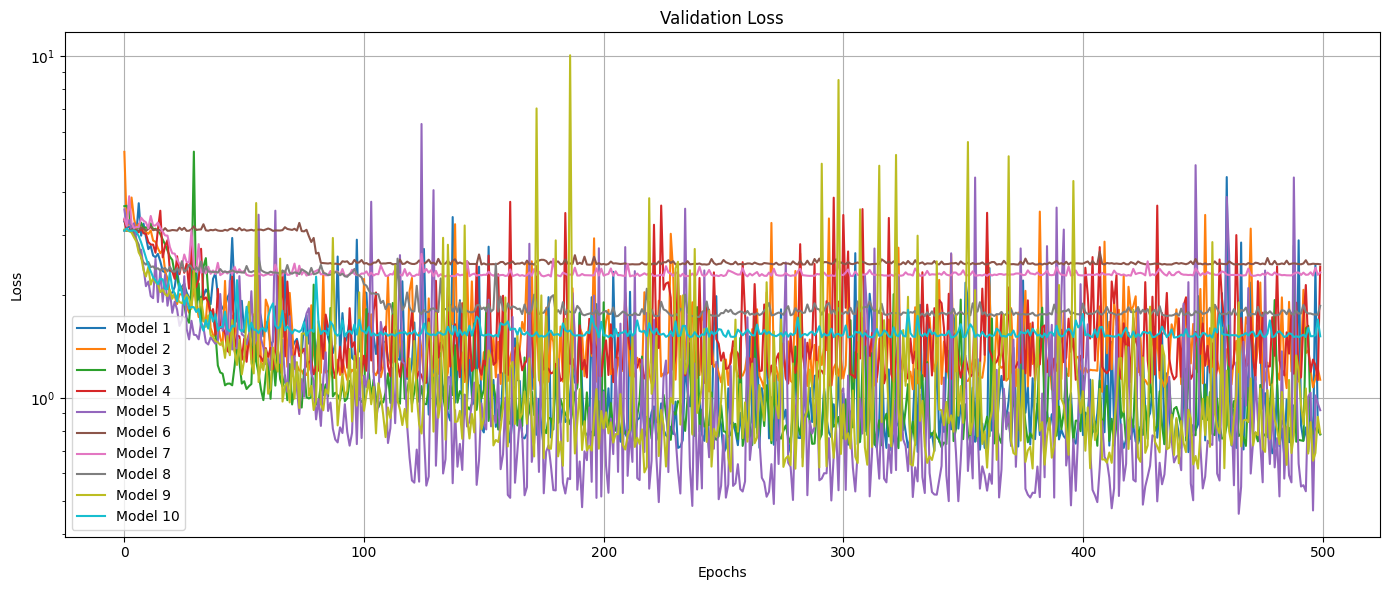

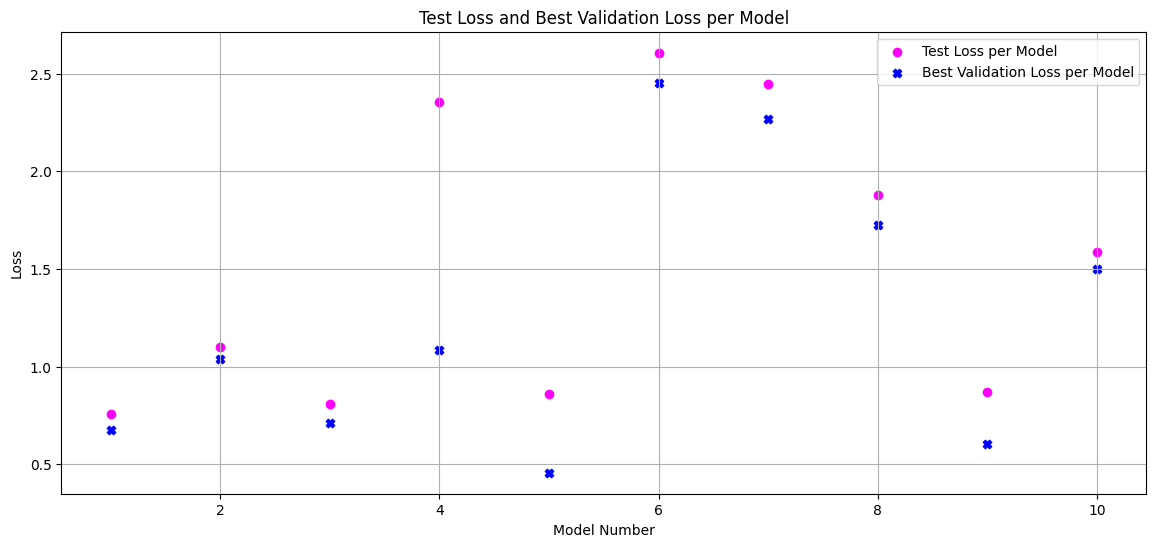

<Figure size 640x480 with 0 Axes>

Test loss model 1/10 = [0.7596498131752014]
Test loss model 2/10 = [1.0997684001922607]
Test loss model 3/10 = [0.8071068525314331]
Test loss model 4/10 = [2.3561503887176514]
Test loss model 5/10 = [0.8585768342018127]
Test loss model 6/10 = [2.606456995010376]
Test loss model 7/10 = [2.4453344345092773]
Test loss model 8/10 = [1.8773826360702515]
Test loss model 9/10 = [0.8688702583312988]
Test loss model 10/10 = [1.588882565498352]


In [5]:

# your code here after you ran it to answer the question, in a comment


class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_single_model(train_loader, test_loader, val_loader, lr, n_epochs, input_size, hidden_neurons, output_size):
    model = FullyConnectedNetwork(input_size, hidden_neurons, output_size)
    train_losses, test_losses, validation_losses, best_val_loss, predictions, ground_truth = train(train_loader, test_loader, val_loader, lr, model, n_epochs, logging=True)
    return train_losses, test_losses, validation_losses, predictions, ground_truth, best_val_loss

"""
# We are fixing hyperparameters
lr = 0.1
n_epochs = 500
hidden_neurons = 16
input_size = X_12_log.shape[1]
output_size = 1

# We chose to train 10 models and collect their learning curves
n_models = 10
all_train_losses = []
all_test_losses = []
all_validation_losses = []
all_test_predictions = []
all_ground_truth = []
all_best_val_losses = []

for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}")
    train_losses, test_losses, validation_losses, predictions, ground_truth, best_val_losses = train_single_model(train_loader, test_loader, val_loader, lr, n_epochs, input_size, hidden_neurons, output_size)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    all_validation_losses.append(validation_losses)
    all_test_predictions.append(predictions)
    all_ground_truth.append(ground_truth)
    all_best_val_losses.append(best_val_losses)

# Plot the learning curves

# Plot training losses
plt.figure(figsize=(14, 6))
for i, losses in enumerate(all_train_losses):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot test losses
plt.figure(figsize=(14, 6))
for i, losses in enumerate(all_validation_losses):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log') 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot test losses for each model
plt.figure(figsize=(14, 6))
model_indices = range(1, len(all_test_losses) + 1)  
plt.scatter(model_indices, all_test_losses, color='fuchsia', marker = "o", label='Test Loss per Model')
plt.scatter(model_indices, all_best_val_losses, color='blue', marker = "X", label='Best Validation Loss per Model')
plt.title('Test Loss and Best Validation Loss per Model')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

for i in range(n_models):
    print(f"Test loss model {i + 1}/{n_models} =", all_test_losses[i])

"""

e) Choose some parameters that reliably give you good models even if you restart the training . If you get a test loss around 0.01 you can stop training. 

*`Answer:`* 
While tuning hyperparameters, I get resonably good results for a learning rate of $0.01$ and a number of epochs of $1500$ leading to at least one model with a test loss less than 0.01 (depending on the runs).

Training model 1/10
Epoch 1/1500, Train Loss: 19.1912, Validation Loss: 6.1804
Epoch 2/1500, Train Loss: 5.2044, Validation Loss: 5.6470
Epoch 3/1500, Train Loss: 4.5252, Validation Loss: 4.7686
Epoch 4/1500, Train Loss: 4.0295, Validation Loss: 4.3648
Epoch 5/1500, Train Loss: 3.5925, Validation Loss: 3.9586
Epoch 6/1500, Train Loss: 3.4500, Validation Loss: 3.6055
Epoch 7/1500, Train Loss: 3.3163, Validation Loss: 3.5627
Epoch 8/1500, Train Loss: 3.1063, Validation Loss: 3.3116
Epoch 9/1500, Train Loss: 3.0821, Validation Loss: 3.2505
Epoch 10/1500, Train Loss: 3.1304, Validation Loss: 3.6621
Epoch 11/1500, Train Loss: 3.0926, Validation Loss: 3.1903
Epoch 12/1500, Train Loss: 3.0632, Validation Loss: 3.2910
Epoch 13/1500, Train Loss: 2.9992, Validation Loss: 3.1843
Epoch 14/1500, Train Loss: 3.0317, Validation Loss: 3.1156
Epoch 15/1500, Train Loss: 2.9337, Validation Loss: 3.1247
Epoch 16/1500, Train Loss: 2.9747, Validation Loss: 3.3051
Epoch 17/1500, Train Loss: 3.0085, Validatio

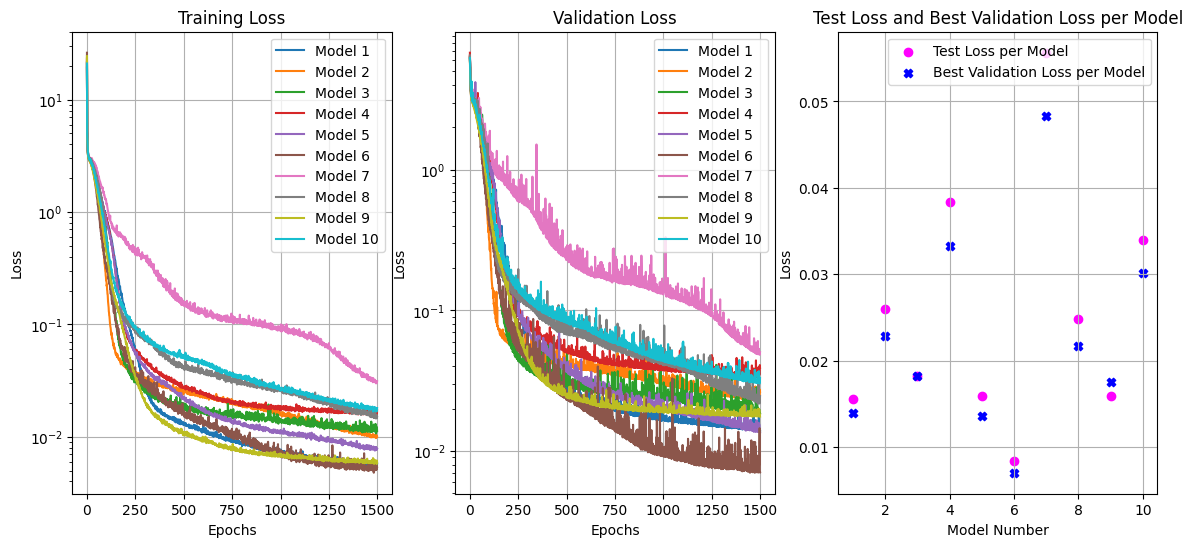

<Figure size 640x480 with 0 Axes>

Test loss model 1/10 = [0.015548291616141796]
Test loss model 2/10 = [0.025934962555766106]
Test loss model 3/10 = [0.01824101433157921]
Test loss model 4/10 = [0.03831268474459648]
Test loss model 5/10 = [0.01588885299861431]
Test loss model 6/10 = [0.008323824033141136]
Test loss model 7/10 = [0.055634766817092896]
Test loss model 8/10 = [0.024792136624455452]
Test loss model 9/10 = [0.015946459025144577]
Test loss model 10/10 = [0.03396729752421379]


In [6]:
# your code here
# We are fixing hyperparameters
lr = 0.01
n_epochs = 1500
hidden_neurons = 16
input_size = X_12_log.shape[1]
output_size = 1

# We chose to train 10 models and collect their learning curves
n_models = 10
all_train_losses_tuned = []
all_test_losses_tuned = []
all_validation_losses_tuned = []
all_test_predictions_tuned = []
all_ground_truth_tuned = []
all_best_val_losses_tuned = []

for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}")
    train_losses, test_losses, validation_losses, predictions, ground_truth, best_val_losses = train_single_model(train_loader, test_loader, val_loader, lr, n_epochs, input_size, hidden_neurons, output_size)
    all_train_losses_tuned.append(train_losses)
    all_test_losses_tuned.append(test_losses)
    all_validation_losses_tuned.append(validation_losses)
    all_test_predictions_tuned.append(predictions)
    all_ground_truth_tuned.append(ground_truth)
    all_best_val_losses_tuned.append(best_val_losses)


# Plot the learning curves
plt.figure(figsize=(14, 6))

# Plot training losses
plt.subplot(1, 3, 1)
for i, losses in enumerate(all_train_losses_tuned):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()

# Plot test losses
plt.subplot(1, 3, 2)
for i, losses in enumerate(all_validation_losses_tuned):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log') 
plt.legend()
plt.grid()

# Plot test losses for each model
plt.subplot(1, 3, 3)
model_indices = range(1, len(all_test_losses_tuned) + 1)  
plt.scatter(model_indices, all_test_losses_tuned, color='fuchsia', marker = "o", label='Test Loss per Model')
plt.scatter(model_indices, all_best_val_losses_tuned, color='blue', marker = "X", label='Best Validation Loss per Model')
plt.title('Test Loss and Best Validation Loss per Model')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

for i in range(n_models):
    print(f"Test loss model {i + 1}/{n_models} =", all_test_losses_tuned[i])


f) For the previous model that you liked, plot the histogram of the distribution again with the log transform, for test data. Also plot the predicted and ground truth values against each other. Are you satisfied with the match?

*`Answer:`* 
We can be resonably satisfied because when plotting predicted values vs ground truth, we see that the general tedency is close to the curve $y_{predicted}=y_{true}$. This can also be seen with the overlapping histogram of the predicted distribution and the true distribution.

Selected Model: Model 6
Test Loss of Selected Model: 0.0083


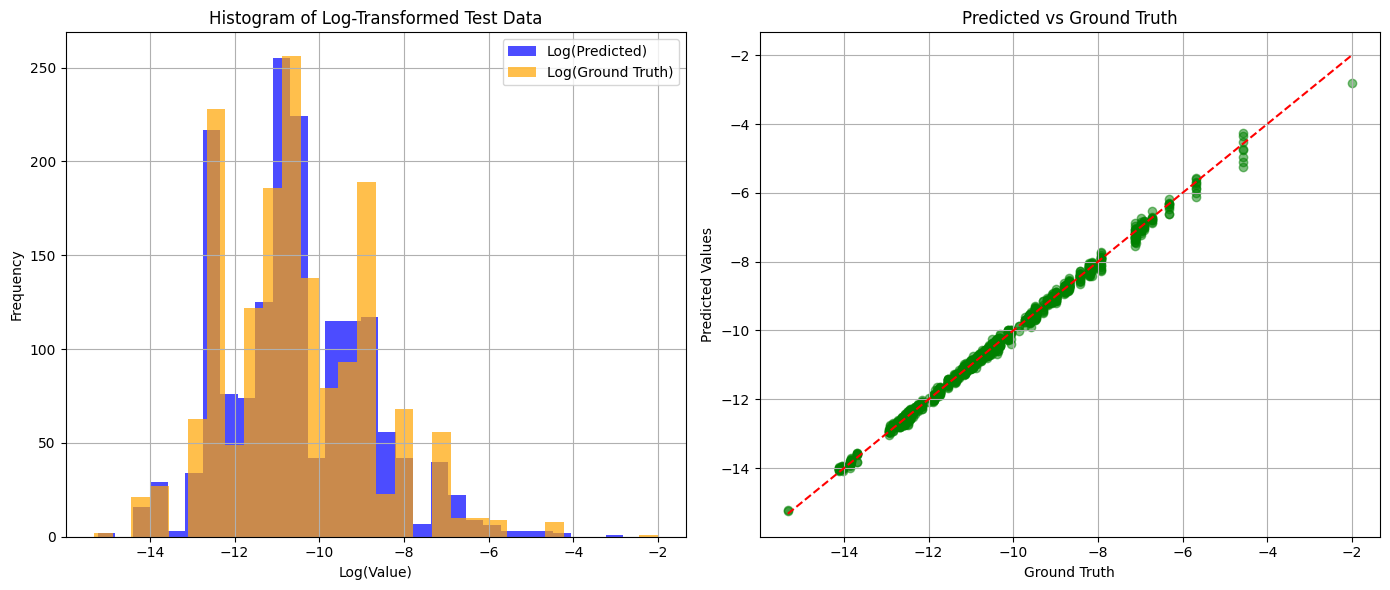

In [7]:
# We select one of the 10 model with the lowest test loss
best_model_index = np.argmin([min(losses) for losses in all_test_losses_tuned])
print(f"Selected Model: Model {best_model_index + 1}")
print(f"Test Loss of Selected Model: {min(all_test_losses_tuned[best_model_index]):.4f}")

selected_predictions_tuned = np.array(all_test_predictions_tuned[best_model_index])
selected_ground_truth_tuned = np.array(all_ground_truth_tuned[best_model_index])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(selected_predictions_tuned, bins=30, alpha=0.7, label='Log(Predicted)', color='blue')
plt.hist(selected_ground_truth_tuned, bins=30, alpha=0.7, label='Log(Ground Truth)', color='orange')
plt.xlabel('Log(Value)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Test Data')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(selected_ground_truth_tuned, selected_predictions_tuned, alpha=0.5, color='green')
plt.plot([min(selected_ground_truth_tuned), max(selected_ground_truth_tuned)],
         [min(selected_ground_truth_tuned), max(selected_ground_truth_tuned)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth')
plt.grid()
plt.tight_layout()
plt.show()




## Exercise 2 (6 pts): Exploring alternative architectures  and losses

You have found a model that works! But can you make it more efficient?

a) A linear regression model would for example use fewer parameters. Try the model and based on your experiment argue that it is less suitable for this task than the fully connected neural network.

*`Answer:`* 
We are trying to predict probabilities $y_i$ corresponding to the outcomes $x_i$ of a quantum state measurement which are typically non-linear in nature. But here with a linear regression, we assume a linear relationship between input $x_i$ and probability distribution $y_i$ which is in general not true for a quantum distribution. In fact, the linear regression model cannot approximate such non-linear dependencies, leading to higher errors and worse performances in this specific task compared to the neural network that uses a non linear activation fonction like ReLU (allows to better capture the structure of the distribution).

Train Loss: 3.0403
Validation Loss: 3.1442
Test Loss: 3.0534


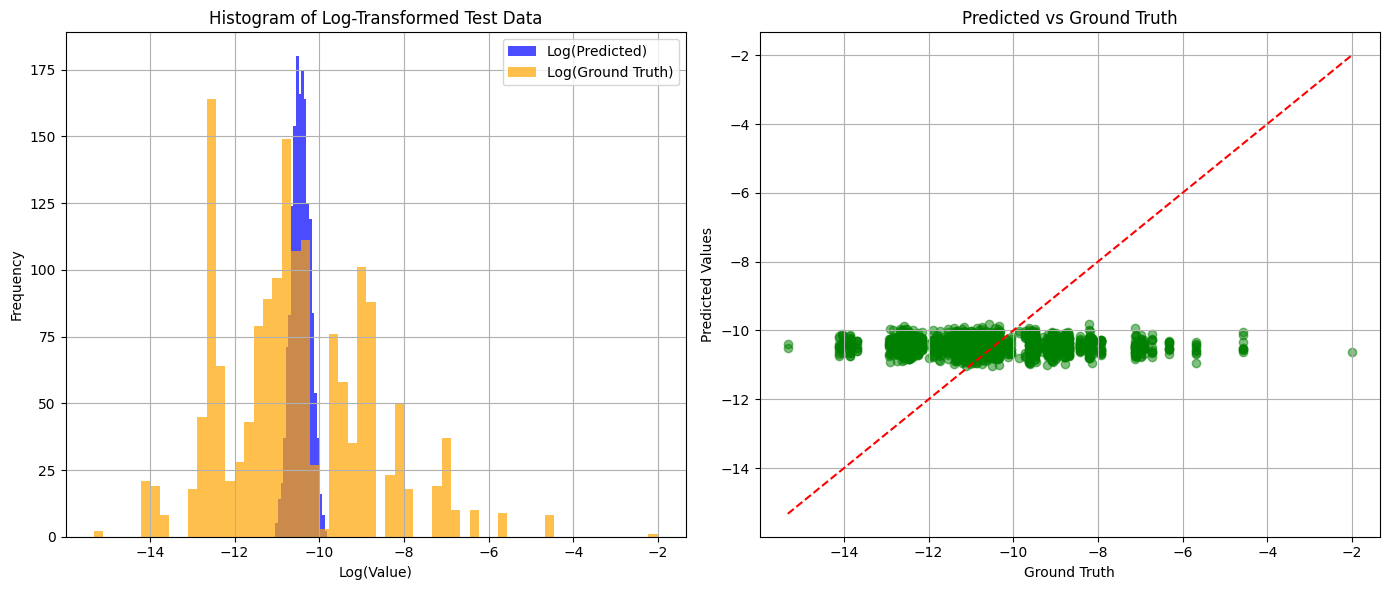

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_reg_model = LinearRegression()
X_train = torch.cat([features for features, _ in train_loader]).numpy()
y_train = torch.cat([labels for _, labels in train_loader]).numpy()
X_test = torch.cat([features for features, _ in test_loader]).numpy()
y_test = torch.cat([labels for _, labels in test_loader]).numpy()
X_val = torch.cat([features for features, _ in val_loader]).numpy()
y_val = torch.cat([labels for _, labels in val_loader]).numpy()

linear_reg_model.fit(X_train, y_train)

y_pred_train = linear_reg_model.predict(X_train)
y_pred_test = linear_reg_model.predict(X_test)
y_pred_val = linear_reg_model.predict(X_val)

mse_train = mean_squared_error(y_train, y_pred_train)
print(f"Train Loss: {mse_train:.4f}")

mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation Loss: {mse_val:.4f}")

mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Test Loss: {mse_test:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(y_pred_test, bins=20, alpha=0.7, label='Log(Predicted)', color='blue')
plt.hist(y_test, bins=60, alpha=0.7, label='Log(Ground Truth)', color='orange')
plt.xlabel('Log(Value)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Test Data')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth')
plt.grid()

plt.tight_layout()
plt.show()

b) If a linear regression does not work, maybe you can fine-tune the number of hidden neurons. Select 5 different values of the hidden neurons `[2,8,16,32,64]` and train those models. Use at max 500 epochs to train every model and a learning rate of 0.01. In reality you would optimize the learning rate for each architecture and you can still do so if you wish, but to save you time we do not require this. After the models are trained, select the best one based on the best test loss. 

Estimate the loss you can expect on the model that you just selected on a fresh data sample, that has not been seen in the process of selecting this model. 

*`Answer:`* 

In order to see which model has been selecter, one can refer to the print of the following : "Selected number of neurons: $N$ " and  "Test Loss of Selected Number of Neurons: $X.XXXX$". Then, one can store this model and compute what we did before in the function train but just the Testing Phase on a fresh data sample. (see third cell, train function, Testing Phase)


Number of neurons used 2
Epoch 1/500, Train Loss: 71.9111, Validation Loss: 42.8417
Epoch 2/500, Train Loss: 26.9957, Validation Loss: 17.4627
Epoch 3/500, Train Loss: 11.4875, Validation Loss: 8.3897
Epoch 4/500, Train Loss: 6.0008, Validation Loss: 5.1309
Epoch 5/500, Train Loss: 4.1309, Validation Loss: 3.8948
Epoch 6/500, Train Loss: 3.4451, Validation Loss: 3.4307
Epoch 7/500, Train Loss: 3.2324, Validation Loss: 3.2539
Epoch 8/500, Train Loss: 3.1173, Validation Loss: 3.1746
Epoch 9/500, Train Loss: 3.1112, Validation Loss: 3.1382
Epoch 10/500, Train Loss: 3.0972, Validation Loss: 3.1216
Epoch 11/500, Train Loss: 3.0689, Validation Loss: 3.1137
Epoch 12/500, Train Loss: 3.0892, Validation Loss: 3.1050
Epoch 13/500, Train Loss: 3.0712, Validation Loss: 3.1034
Epoch 14/500, Train Loss: 3.0784, Validation Loss: 3.1021
Epoch 15/500, Train Loss: 3.0578, Validation Loss: 3.1020
Epoch 16/500, Train Loss: 3.0898, Validation Loss: 3.1019
Epoch 17/500, Train Loss: 3.0873, Validation Loss: 

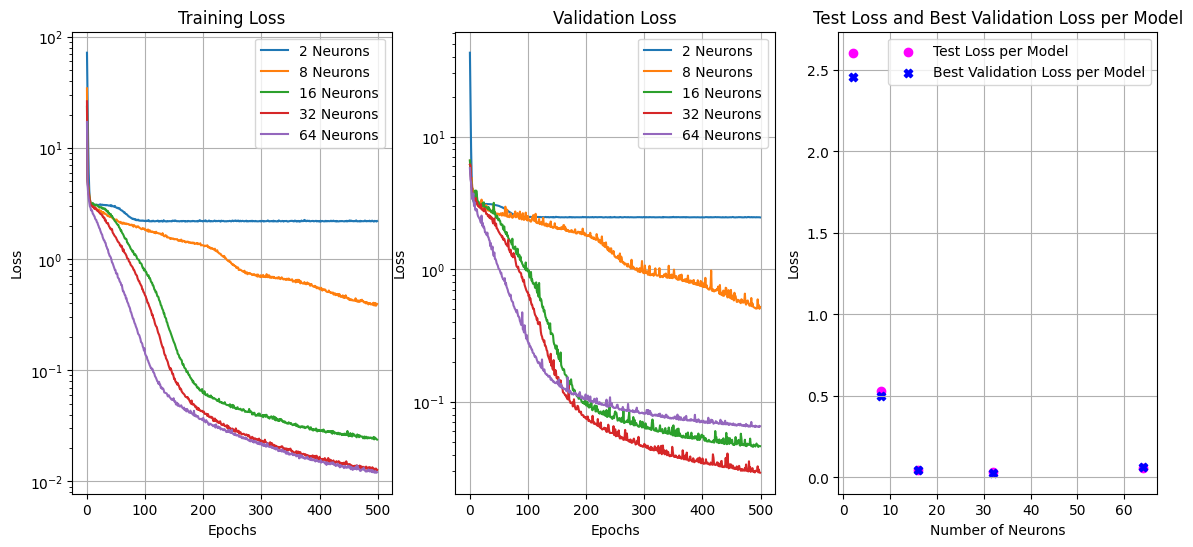

<Figure size 640x480 with 0 Axes>

Test Loss for a Number of neurons of : 2 = [2.605626106262207]
Test Loss for a Number of neurons of : 8 = [0.530198872089386]
Test Loss for a Number of neurons of : 16 = [0.046791430562734604]
Test Loss for a Number of neurons of : 32 = [0.03180593624711037]
Test Loss for a Number of neurons of : 64 = [0.06060020998120308]
Selected number of neurons:  32
Test Loss of Selected Number of Neurons: 0.0318


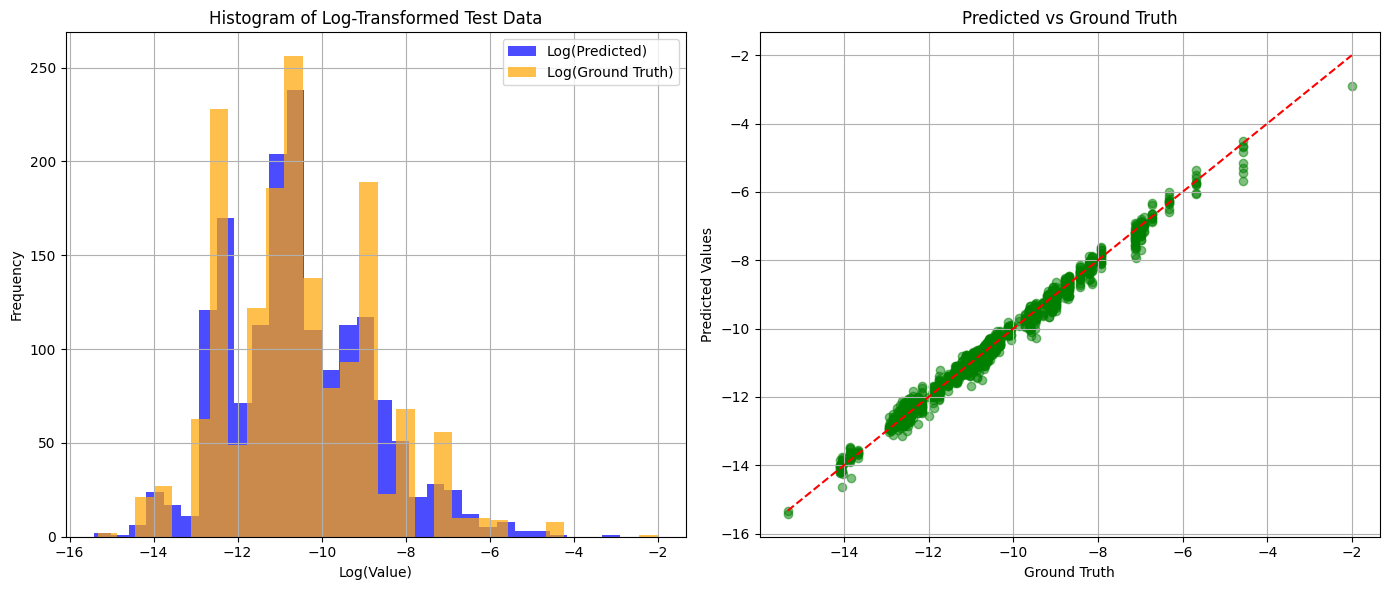

In [9]:
# your code here
lr = 0.01
n_epochs = 500
hidden_neurons_list = [2, 8, 16, 32, 64] 
input_size = X_12_log.shape[1]
output_size = 1
all_train_losses_number = []
all_test_losses_number = []
all_validation_losses_number = []
all_test_predictions_number = []
all_ground_truth_number = []
all_best_val_losses_number = []

for i, hidden_neurons in enumerate(hidden_neurons_list):
    print(f"Number of neurons used {hidden_neurons}")
    train_losses, test_losses, validation_losses, predictions, ground_truth, best_val_losses = train_single_model(train_loader, test_loader, val_loader, lr, n_epochs, input_size, hidden_neurons, output_size)
    all_train_losses_number.append(train_losses)
    all_test_losses_number.append(test_losses)
    all_validation_losses_number.append(validation_losses)
    all_test_predictions_number.append(predictions)
    all_ground_truth_number.append(ground_truth)
    all_best_val_losses_number.append(best_val_losses)

# Plot the learning curves
plt.figure(figsize=(14, 6))

# Plot training losses
plt.subplot(1, 3, 1)
for i, losses in enumerate(all_train_losses_number):
    plt.plot(range(n_epochs), losses, label=f'{hidden_neurons_list[i]} Neurons')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()

# Plot test losses
plt.subplot(1, 3, 2)
for i, losses in enumerate(all_validation_losses_number):
    plt.plot(range(n_epochs), losses, label=f'{hidden_neurons_list[i]} Neurons')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log') 
plt.legend()
plt.grid()

# Plot test losses for each number of neurons
plt.subplot(1, 3, 3)
plt.scatter(hidden_neurons_list, all_test_losses_number, color='fuchsia', marker = "o", label='Test Loss per Model')
plt.scatter(hidden_neurons_list, all_best_val_losses_number, color='blue', marker = "X", label='Best Validation Loss per Model')
plt.title('Test Loss and Best Validation Loss per Model')
plt.xlabel('Number of Neurons')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

for i, hidden_neurons in enumerate(hidden_neurons_list):
    print(f"Test Loss for a Number of neurons of : {hidden_neurons} =", all_test_losses_number[i])

# We select the number of neurons that gave the best test loss
best_number_index = np.argmin([min(losses) for losses in all_test_losses_number])
print(f"Selected number of neurons:  {hidden_neurons_list[best_number_index]}")
print(f"Test Loss of Selected Number of Neurons: {min(all_test_losses_number[best_number_index]):.4f}")

selected_predictions_number = np.array(all_test_predictions_number[best_number_index])
selected_ground_truth_number = np.array(all_ground_truth_number[best_number_index])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(selected_predictions_number, bins=30, alpha=0.7, label='Log(Predicted)', color='blue')
plt.hist(selected_ground_truth_number, bins=30, alpha=0.7, label='Log(Ground Truth)', color='orange')
plt.xlabel('Log(Value)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Test Data')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(selected_ground_truth_number, selected_predictions_number, alpha=0.5, color='green')
plt.plot([min(selected_ground_truth_number), max(selected_ground_truth_number)],
         [min(selected_ground_truth_number), max(selected_ground_truth_number)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth')
plt.grid()
plt.tight_layout()
plt.show()




c) Now you want to see what difference the log transformation we applied at the very beginning makes. Train a model on the plain data and compare the models prediction again both via the histogram of y-values and the scatterplot between the predicted and true y, in the log transform. What did the non-log transformed model learn and why?

*`Answer:`* 

- Learning Behavior of the Non-Log Transformed Model :
    - histogram for the non-log model : The blue curve shows predictions concentrated around 0, this shows that the model learned the most common value. Indeed we have a significant proportion of values close to 0.
    -  The scatter plot on the left shows that the non-log model approximates the data trend but struggles with precision for values away from the center/slighly changing. Thus, we understand that for non log-transformed data, the model fails to capture the full variance of the data, notably smaller values in variance.One could say that the resolution of the model for predicting is not good enough

- Why this struggling ?
    - On the histogram where model based on no-log transformed and log transformed datas are compared, one can see that the blue curve of no-log is shifted and poorly overlapping with the ground truth comopared to the predicted distribution by model trained with log-transformed data.
    - This is observed because the log-transformed model better handles skewed data by focusing on proportional relationships over absolute differences.
    - On the other hand,the model trained without the log transformation is sensitive to the concentration of larger values and struggles to adjust when we apply the `np.log()`. Indeed we didn't normalize this skewness with a previous log transform of raw data before training.

- Conclusion : The non-log model predicts values close to the center (ie most common values) but struggles with smaller values due to the skewed data distribution (difficult to capture small variances). But, concerning the log-transformed model, it normalizes skewness, leading to align better predictions with the log-scale ground truth.

Training model 1/1
Epoch 1/500, Train Loss: 0.0289, Validation Loss: 0.0138
Epoch 2/500, Train Loss: 0.0115, Validation Loss: 0.0106
Epoch 3/500, Train Loss: 0.0093, Validation Loss: 0.0091
Epoch 4/500, Train Loss: 0.0080, Validation Loss: 0.0080
Epoch 5/500, Train Loss: 0.0071, Validation Loss: 0.0070
Epoch 6/500, Train Loss: 0.0063, Validation Loss: 0.0062
Epoch 7/500, Train Loss: 0.0056, Validation Loss: 0.0056
Epoch 8/500, Train Loss: 0.0050, Validation Loss: 0.0050
Epoch 9/500, Train Loss: 0.0045, Validation Loss: 0.0045
Epoch 10/500, Train Loss: 0.0041, Validation Loss: 0.0041
Epoch 11/500, Train Loss: 0.0037, Validation Loss: 0.0037
Epoch 12/500, Train Loss: 0.0035, Validation Loss: 0.0034
Epoch 13/500, Train Loss: 0.0032, Validation Loss: 0.0032
Epoch 14/500, Train Loss: 0.0029, Validation Loss: 0.0029
Epoch 15/500, Train Loss: 0.0027, Validation Loss: 0.0027
Epoch 16/500, Train Loss: 0.0026, Validation Loss: 0.0025
Epoch 17/500, Train Loss: 0.0024, Validation Loss: 0.0024
Epoc

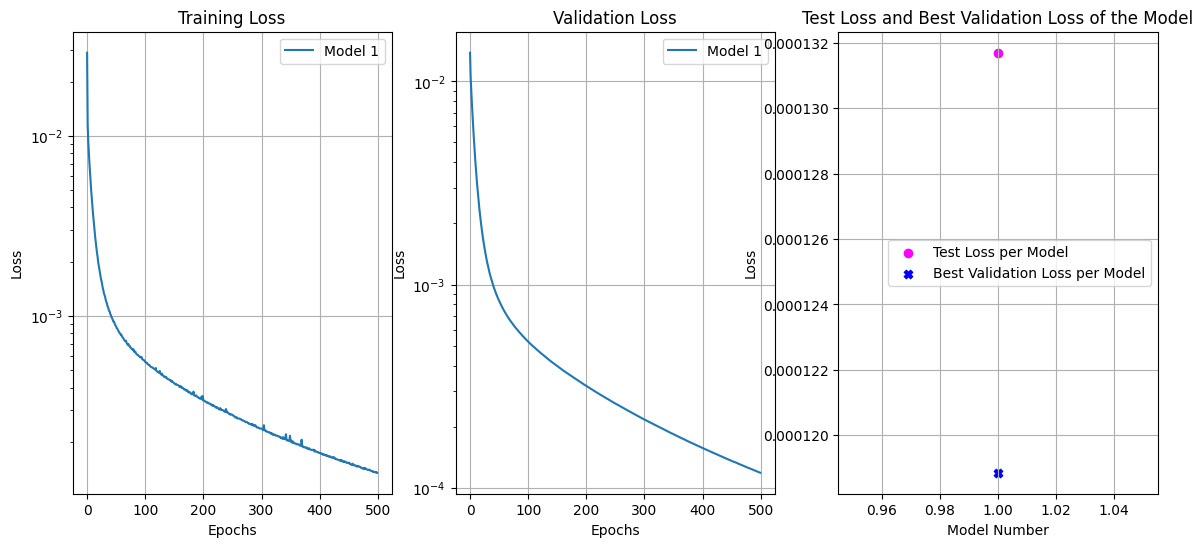

<Figure size 640x480 with 0 Axes>

Test loss model 1/1 = [0.00013169679732527584]
Test Loss of Model: 0.00013170


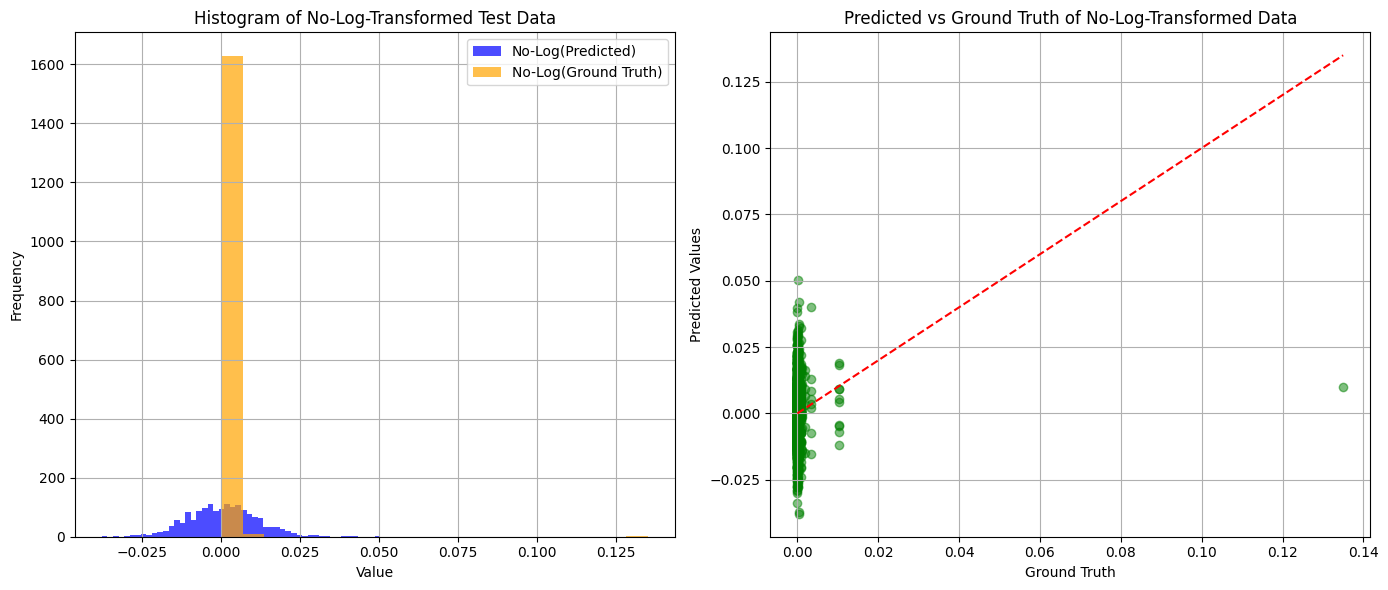

/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_6727/2921428467.py:100: RuntimeWarning: invalid value encountered in log
  log_selected_predictions_12 = np.log(selected_predictions_12)


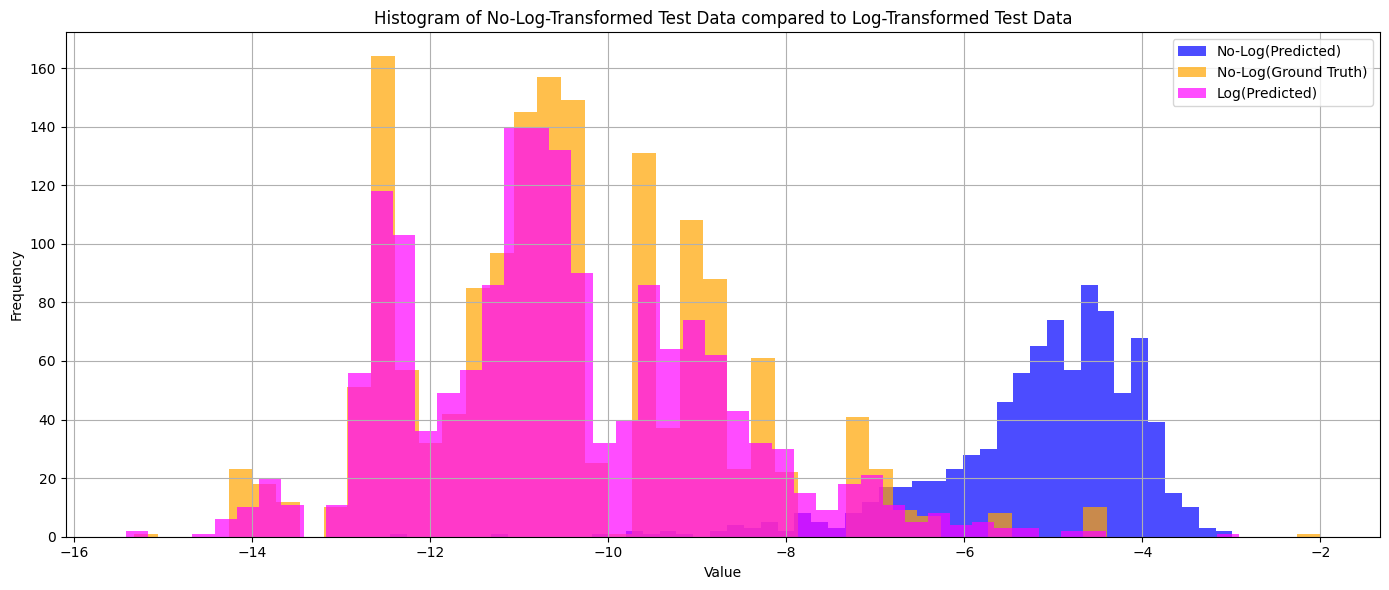

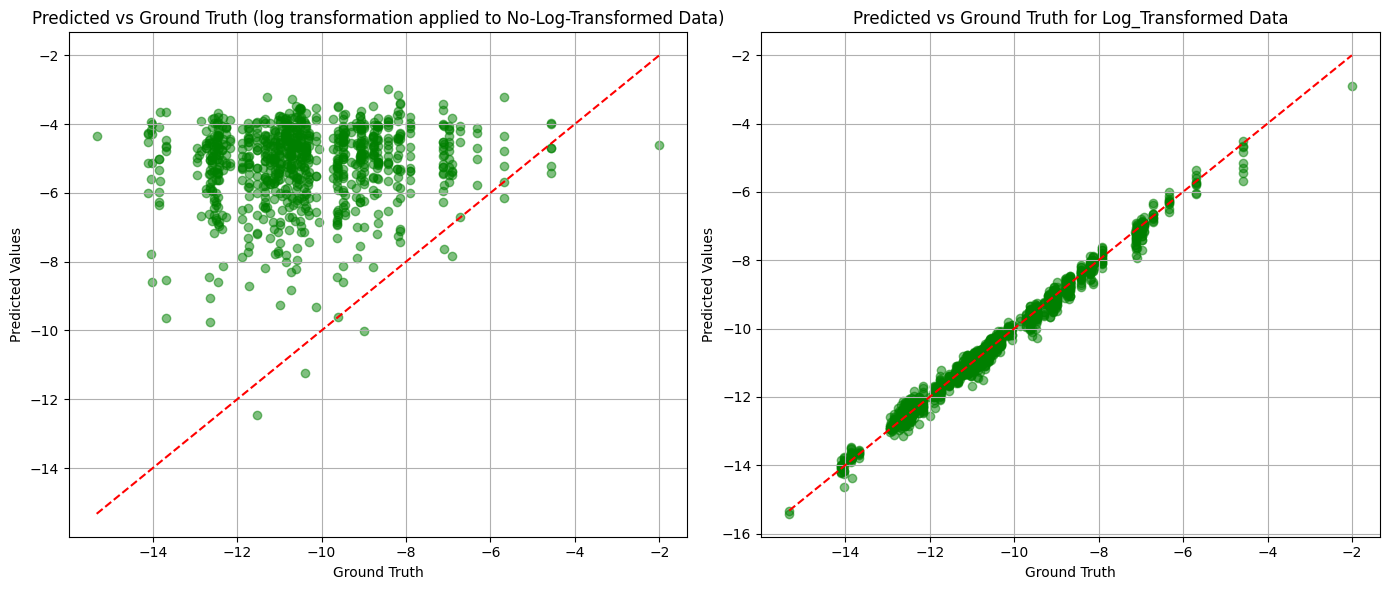

In [10]:
n_spins = 12
X_12_no_log, Y_12_no_log = get_data(n_spins)
train_loader, val_loader, test_loader = get_loaders(X_12_no_log, Y_12_no_log, normalize_log=False)

# We are fixing hyperparameters (we take the same number of neurons as in the best previous model in order to compare)
lr = 0.01
n_epochs = 500
hidden_neurons = hidden_neurons_list[best_number_index]
input_size = X_12_no_log.shape[1]
output_size = 1
n_models = 1
all_train_losses_12 = []
all_test_losses_12 = []
all_validation_losses_12 = []
all_test_predictions_12 = []
all_ground_truth_12 = []
all_best_val_losses_12 = []

for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}")
    train_losses, test_losses, validation_losses, predictions, ground_truth, best_val_losses = train_single_model(train_loader, test_loader, val_loader, lr, n_epochs, input_size, hidden_neurons, output_size)
    all_train_losses_12.append(train_losses)
    all_test_losses_12.append(test_losses)
    all_validation_losses_12.append(validation_losses)
    all_test_predictions_12.append(predictions)
    all_ground_truth_12.append(ground_truth)
    all_best_val_losses_12.append(best_val_losses)

# Plot the learning curves
plt.figure(figsize=(14, 6))

# Plot training losses
plt.subplot(1, 3, 1)
for i, losses in enumerate(all_train_losses_12):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()

# Plot test losses
plt.subplot(1, 3, 2)
for i, losses in enumerate(all_validation_losses_12):
    plt.plot(range(n_epochs), losses, label=f'Model {i + 1}')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log') 
plt.legend()
plt.grid()

# Plot test losses for each model
plt.subplot(1, 3, 3)
model_indices = range(1, len(all_test_losses_12) + 1)  
plt.scatter(model_indices, all_test_losses_12, color='fuchsia', marker = "o", label='Test Loss per Model')
plt.scatter(model_indices, all_best_val_losses_12, color='blue', marker = "X", label='Best Validation Loss per Model')
plt.title('Test Loss and Best Validation Loss of the Model')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

for i in range(n_models):
    print(f"Test loss model {i + 1}/{n_models} =", all_test_losses_12[i])

best_model_index = np.argmin([min(losses) for losses in all_test_losses_12])
print(f"Test Loss of Model: {min(all_test_losses_12[best_model_index]):.8f}")
selected_predictions_12 = np.array(all_test_predictions_12[best_model_index])
selected_ground_truth_12 = np.array(all_ground_truth_12[best_model_index])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(selected_predictions_12, bins=50, alpha=0.7, label='No-Log(Predicted)', color='blue')
plt.hist(selected_ground_truth_12, bins=20, alpha=0.7, label='No-Log(Ground Truth)', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of No-Log-Transformed Test Data')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(selected_ground_truth_12, selected_predictions_12, alpha=0.5, color='green')
plt.plot([min(selected_ground_truth_12), max(selected_ground_truth_12)],
         [min(selected_ground_truth_12), max(selected_ground_truth_12)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth of No-Log-Transformed Data')
plt.grid()
plt.tight_layout()
plt.show()


log_selected_predictions_12 = np.log(selected_predictions_12)
log_selected_ground_truth_12 = np.log(selected_ground_truth_12)

plt.figure(figsize=(14, 6))
plt.hist(log_selected_predictions_12, bins=50, alpha=0.7, label='No-Log(Predicted)', color='blue')
plt.hist(log_selected_ground_truth_12, bins=50, alpha=0.7, label='No-Log(Ground Truth)', color='orange')
plt.hist(selected_predictions_number, bins=50, alpha=0.7, label='Log(Predicted)', color='fuchsia')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of No-Log-Transformed Test Data compared to Log-Transformed Test Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(log_selected_ground_truth_12,log_selected_predictions_12, alpha=0.5, color='green')
plt.plot([min(log_selected_ground_truth_12), max(log_selected_ground_truth_12)],
         [min(log_selected_ground_truth_12), max(log_selected_ground_truth_12)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth (log transformation applied to No-Log-Transformed Data)')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(selected_ground_truth_number, selected_predictions_number, alpha=0.5, color='green')
plt.plot([min(selected_ground_truth_number), max(selected_ground_truth_number)],
         [min(selected_ground_truth_number), max(selected_ground_truth_number)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Ground Truth for Log_Transformed Data')
plt.grid()
plt.tight_layout()
plt.show()


